In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D,
    LSTM,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("GPUs available:", tf.config.list_physical_devices('GPU'))


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [29]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [30]:
normal = pd.read_csv("ptbdb_normal.csv", header=None)
abnormal = pd.read_csv("ptbdb_abnormal.csv", header=None)

normal["label"] = 0
abnormal["label"] = 1

data = pd.concat([normal, abnormal], axis=0)

X = data.iloc[:, :-1].values
y = data["label"].values

print("Normal shape:", normal.shape)
print("Abnormal shape:", abnormal.shape)
print("Total shape:", data.shape)


Normal shape: (4046, 189)
Abnormal shape: (10506, 189)
Total shape: (14552, 189)


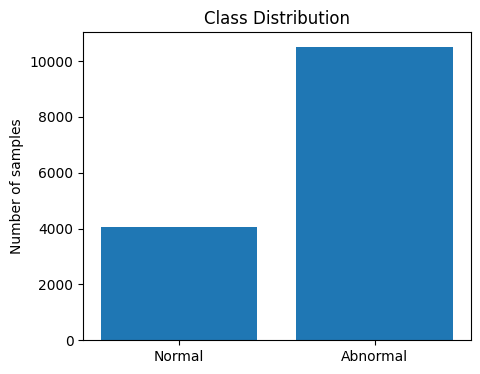

In [21]:
labels, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(5,4))
plt.bar(labels, counts)
plt.xticks([0,1], ["Normal", "Abnormal"])
plt.title("Class Distribution")
plt.ylabel("Number of samples")
plt.show()


In [ ]:
#Plot 1 ECG sample

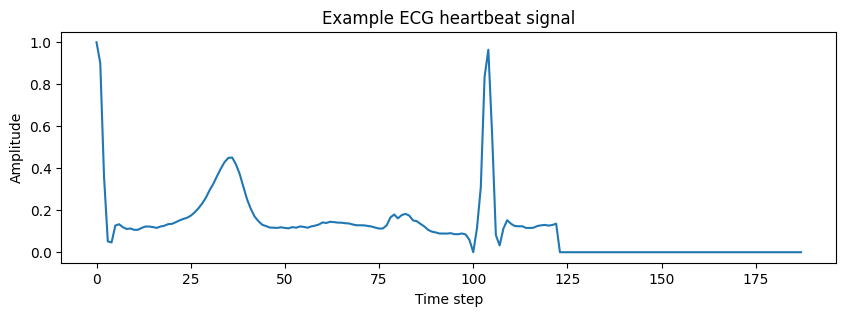

In [22]:
plt.figure(figsize=(10,3))
plt.plot(X[0])
plt.title("Example ECG heartbeat signal")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.show()


In [42]:
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X)

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.37611297 0.12562672 0.06899042]


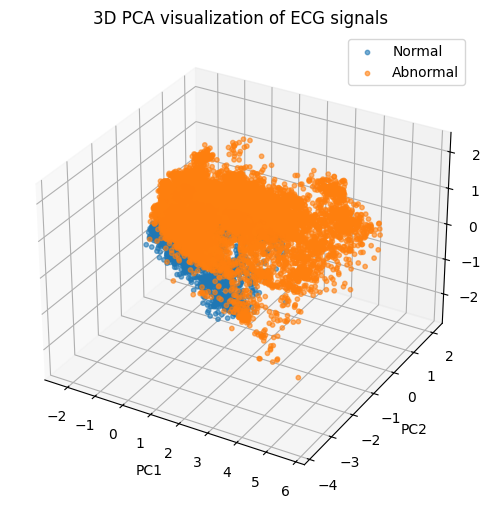

In [43]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for label, color, name in zip(
    [0, 1],
    ['blue', 'red'],
    ['Normal', 'Abnormal']
):
    idx = y == label
    ax.scatter(
        X_3d[idx, 0],
        X_3d[idx, 1],
        X_3d[idx, 2],
        label=name,
        alpha=0.6,
        s=10
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA visualization of ECG signals")
ax.legend()

plt.show()


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)



Train: (11641, 188)
Test : (2911, 188)


In [32]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)   # fit ONLY on train
X_test = scaler.transform(X_test)

# reshape cho CNN + LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Train reshaped:", X_train.shape)
print("Test reshaped :", X_test.shape)



Train reshaped: (11641, 188, 1)
Test reshaped : (2911, 188, 1)


In [7]:
#build cnn model 1D

In [33]:
model = Sequential([
    Conv1D(32, kernel_size=7, activation="relu",
           input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(64, kernel_size=5, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(2),

    LSTM(32),   # temporal modeling

    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 182, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 182, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 87, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,449 (95.50 KB)

 Trainable params: 24,257 (94.75 KB)

 Non-trainable params: 192 (768.00 B)

In [34]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)




In [35]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7021 - loss: 0.5828 - val_accuracy: 0.7278 - val_loss: 0.5518
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8092 - loss: 0.4469 - val_accuracy: 0.7462 - val_loss: 0.5661
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8667 - loss: 0.3542 - val_accuracy: 0.7883 - val_loss: 0.5033
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8952 - loss: 0.2750 - val_accuracy: 0.9279 - val_loss: 0.2093
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9243 - loss: 0.2190 - val_accuracy: 0.8729 - val_loss: 0.3283
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9304 - loss: 0.2101 - val_accuracy: 0.9334 - val_loss: 0.1822
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9384 - loss: 0.1846 - val_accuracy: 0.9592 - val_loss: 0.1270
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9518 - loss: 0.1442 - val_accuracy: 

In [36]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       809
           1       0.97      0.99      0.98      2102

    accuracy                           0.97      2911
   macro avg       0.97      0.95      0.96      2911
weighted avg       0.97      0.97      0.97      2911

Confusion Matrix:
[[ 735   74]
 [  12 2090]]


In [12]:
#yperparameter experiment

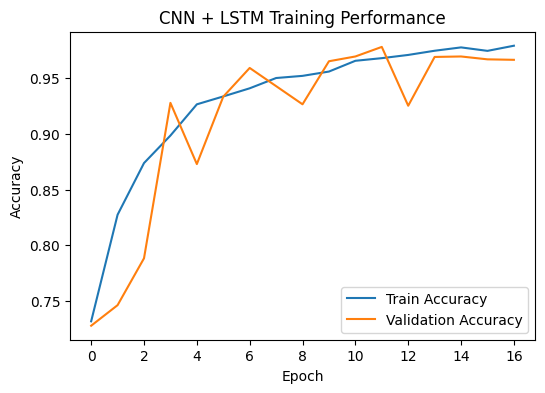

In [37]:
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN + LSTM Training Performance")
plt.show()



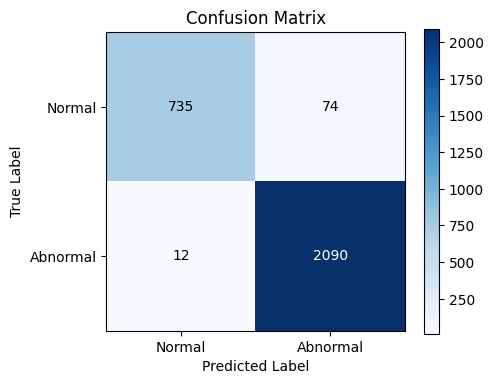

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#cal the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#class
class_names = ["Normal", "Abnormal"]

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
